# **Reference**
Part of the script is modified from
https://www.tensorflow.org/tutorials/keras/classification

In [1]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

## **Dataset**
Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1

https://data.mendeley.com/datasets/4drtyfjtfy/1



In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

import matplotlib.image as img
import skimage.io as io
import sklearn.utils as utils
import skimage.transform as trans

2.10.0


## **遭遇問題-1**
zip解壓後是一堆圖檔，無標籤，副檔名，圖片大小未統一

## **解法**
手動將檔案分進不同資料夾並統一命名

# **1.Initialize**
Assign the class names, number of classes, number of data, labels
*labels are numbers, class names are strings

In [3]:
#init

class_names = ['cloudy','rain','shine','sunrise']
classnum = len(class_names)
datanum = np.array([300,215,253,357]).astype(int)
# divnum = datanum*0.8
# divnum = divnum.astype(int)
labels = []
for i in range(classnum):
  labels.append(i)

In [4]:
# print(divnum,labels, sep='\n')

# **2.Filepath/Filename**
Assign the filepathes </n>

**rootfolder:** filepath of root

**classfolder:** list of folder name of each class

**filename:** 2d list of filename [label][index]


root─┬─class1─┬filename1
</n>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└filename2
</n>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─class2─
&nbsp;┬filename3


In [5]:
#filepath

rootfolder = 'dataset2'
classfolder = []
filename = []
for i in labels:
  classfolder.append('/'+class_names[i])
  filename.append([])
  for j in range(1,(datanum[i]+1)):
    tmpstr = '/'+class_names[i]+' ('+str(j)+').jpg'
    filename[i].append(tmpstr)

In [6]:
# print(classfolder,filename, sep='\n')

# **3.Load Images**

Load all files as a list and create a corresponding label list

### Reference for loading image:

Fastest approach to read thousands of images into one big numpy array
https://stackoverflow.com/questions/44078327/fastest-approach-to-read-thousands-of-images-into-one-big-numpy-array

Importing Image Data into NumPy Arrays
https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

In [7]:
#load image

# imagelist = []
# for i in labels:
#   fd = rootfolder+classfolder[i]
#   imagelist.append([])
#   for j in range(datanum[i]):
#     fp=fd+filename[i][j]
#     imagelist[i].append(io.imread(fp))

imagelist = []
width = 128
height = 128
for i in labels:
  fd = rootfolder+classfolder[i]
  for j in range(datanum[i]):
    fp=fd+filename[i][j]
    image = io.imread(fp)
    image_resized = trans.resize(image, (width ,height), anti_aliasing=True)
    imagelist.append(image_resized)

<class 'numpy.ndarray'>
float64
(128, 128, 3)


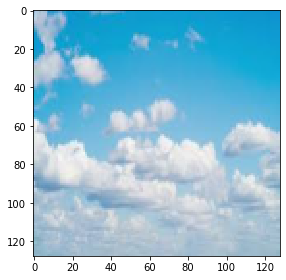

In [8]:
#show image

classindex = 2    #0,1,2,3
imageindex = 120   #300,215,253,357 (max)
index = np.sum(datanum[:classindex])+imageindex
image = imagelist[index]
print(type(image))
print(image.dtype)
print(image.shape)
io.imshow(image)

In [9]:
#list of labels corresponding to the images

labelarray = []
for i in labels:
  tmp = np.full(datanum[i], i)
  labelarray=np.append(labelarray,tmp)
labellist = labelarray.astype(int).tolist()

In [10]:
#remove corrupt data
imgshape = (width,height,3)
popindex=[]
for i in range(len(imagelist)):
  j=imagelist[i]
  if j.shape != imgshape :
    # print(i,j.shape)
    popindex.append(i)
for index in sorted(popindex, reverse=True):
  del imagelist[index]
  del labellist[index]
datanum=len(labellist)

# **4.Shuffle & Split**

Turn the list to ndarray for faster calculation and more convenient operation.

Shuffle the data and labels together then divide them into test group and valid group.

In [11]:
#to array

labelarray = np.array(labellist)
imagearray = np.stack(imagelist,axis=0)

In [12]:
# io.imshow(imagearray[666])

In [13]:
#shuffle

shuffler = np.random.permutation(datanum)
shuffledlabels = labelarray[shuffler]
shuffledimages = imagearray[shuffler]

In [14]:
# print(shuffledimages.shape)

In [15]:
#split (train/valid)

alldatanum = int(np.sum(datanum))
div = int(alldatanum*0.8)
train_images = shuffledimages[:div]
train_labels = shuffledlabels[:div]
test_images = shuffledimages[div:]
test_labels = shuffledlabels[div:]

In [16]:
# print(train_images.shape)

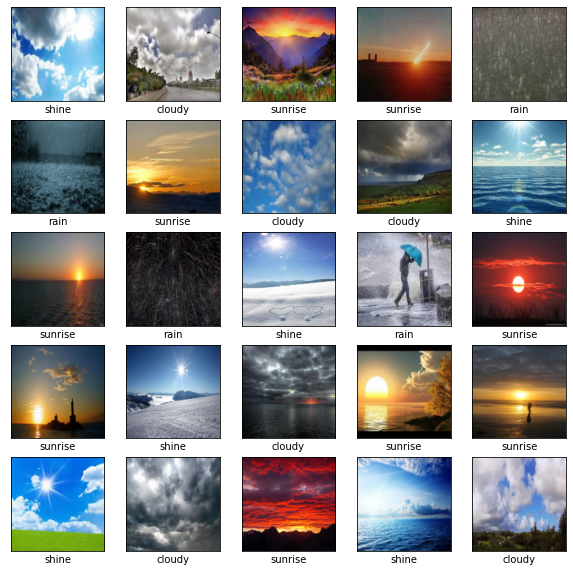

In [17]:
#train data visualization 

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i])
  plt.xlabel(class_names[train_labels[i]])
plt.show()

In [18]:
test_images /= 255.0
train_images /= 255.0

# **5.Create the model**

Add arbritrary layers with arbritrary number of nodes and activate function in each layer.
In the last layer, let the #nodes = #classes.

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(classnum)
])

In [20]:
model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [21]:
model.fit(train_images, train_labels, epochs=20)

Epoch 1/20
28/28 [==============================] - 1s 21ms/step - loss: 1.3530 - accuracy: 0.3817
Epoch 2/20
28/28 [==============================] - 1s 21ms/step - loss: 1.1813 - accuracy: 0.5725
Epoch 3/20
28/28 [==============================] - 1s 21ms/step - loss: 0.9009 - accuracy: 0.6328
Epoch 4/20
28/28 [==============================] - 1s 21ms/step - loss: 0.7398 - accuracy: 0.6931
Epoch 5/20
28/28 [==============================] - 1s 22ms/step - loss: 0.7327 - accuracy: 0.6674
Epoch 6/20
28/28 [==============================] - 1s 21ms/step - loss: 0.6823 - accuracy: 0.7176
Epoch 7/20
28/28 [==============================] - 1s 21ms/step - loss: 0.6552 - accuracy: 0.7355
Epoch 8/20
28/28 [==============================] - 1s 21ms/step - loss: 0.6087 - accuracy: 0.7533
Epoch 9/20
28/28 [==============================] - 1s 21ms/step - loss: 0.5971 - accuracy: 0.7790
Epoch 10/20
28/28 [==============================] - 1s 21ms/step - loss: 0.5586 - accuracy: 0.7868
Epoch 11/

# **6.Validation**

In [22]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

7/7 - 0s - loss: 0.4385 - accuracy: 0.8348 - 193ms/epoch - 28ms/step

Test accuracy: 0.8348214030265808


## **遭遇問題-2**
準確率很吃運氣，有時候一開始Loss就不大準確率也很快就超過0.8。但有時訓練了10個epoch準確率還在0.6那附近掙扎。

## **想法**
可不可以訓練n個epoch直到準確率跟loss達到一定標準為止XD
(沒restart kernal 好像parameter不會 reset)